<a href="https://colab.research.google.com/github/arrnavgg/SnackSafe/blob/main/SnackSafe%20model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import kagglehub

# Use the path returned by kagglehub.dataset_download
MAIN_DIR = kagglehub.dataset_download('concaption/pepsico-lab-potato-quality-control')

print('Data source import complete.')

Data source import complete.


<div class="alert alert-success" role="alert">
<p>
In this project, images of chips are classified into two classes to ensure control over quality of the chips. For this image binary classification task, following models have been created:
<ul>    
    <li>Custom CNN model</li>
    <li>Custom CNN model with Data Augmentation</li>
</ul>
</p>
</div>

# Setup

In [18]:
import pandas as pd
import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from keras.layers import Input, Activation, LeakyReLU, Dropout
from keras.losses import BinaryCrossentropy
try:
    from keras.optimizer import Adam
except:
    from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG

from sklearn.metrics import classification_report, confusion_matrix

### Setting up Callbacks

In [19]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=0)
earlystopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=3,
                              verbose=1,
                              restore_best_weights=True)

# Loading the Images

In [20]:
train_dir = MAIN_DIR + "/Pepsico RnD Potato Lab Dataset/Train"
test_dir = MAIN_DIR + "/Pepsico RnD Potato Lab Dataset/Test"

In [21]:
for dirpath, dirnames, filenames in os.walk(MAIN_DIR):
    print(f"{len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

1 directories and 0 images in '/kaggle/input/pepsico-lab-potato-quality-control'
2 directories and 0 images in '/kaggle/input/pepsico-lab-potato-quality-control/Pepsico RnD Potato Lab Dataset'
2 directories and 1 images in '/kaggle/input/pepsico-lab-potato-quality-control/Pepsico RnD Potato Lab Dataset/Test'
0 directories and 101 images in '/kaggle/input/pepsico-lab-potato-quality-control/Pepsico RnD Potato Lab Dataset/Test/Not Defective'
0 directories and 93 images in '/kaggle/input/pepsico-lab-potato-quality-control/Pepsico RnD Potato Lab Dataset/Test/Defective'
2 directories and 1 images in '/kaggle/input/pepsico-lab-potato-quality-control/Pepsico RnD Potato Lab Dataset/Train'
0 directories and 401 images in '/kaggle/input/pepsico-lab-potato-quality-control/Pepsico RnD Potato Lab Dataset/Train/Non-Defective'
0 directories and 370 images in '/kaggle/input/pepsico-lab-potato-quality-control/Pepsico RnD Potato Lab Dataset/Train/Defective'


In [22]:
# Verify the contents of the downloaded directory
!ls {MAIN_DIR}
!ls {MAIN_DIR}/Train # Check if the Train directory exists and its contents
!ls {MAIN_DIR}/Test # Check if the Test directory exists and its contents

'Pepsico RnD Potato Lab Dataset'
ls: cannot access '/kaggle/input/pepsico-lab-potato-quality-control/Train': No such file or directory
ls: cannot access '/kaggle/input/pepsico-lab-potato-quality-control/Test': No such file or directory


In [23]:
IMAGE_SIZE = (224,224)
BATCH_SIZE = 32

train_datagen = IDG(rescale=1./255, validation_split=0.2)
test_datagen = IDG(rescale=1./255)

train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               batch_size=BATCH_SIZE,
                                               target_size=IMAGE_SIZE,
                                               class_mode="binary",
                                               subset="training",
                                               shuffle=True,
                                               seed=40)

valid_data = train_datagen.flow_from_directory(directory=train_dir,
                                               batch_size=BATCH_SIZE,
                                               target_size=IMAGE_SIZE,
                                               class_mode="binary",
                                               subset="validation",
                                               shuffle=True,
                                               seed=40)


test_data = test_datagen.flow_from_directory(directory=test_dir,
                                               batch_size=BATCH_SIZE,
                                               target_size=IMAGE_SIZE,
                                               class_mode="binary",
                                               shuffle=False,
                                               seed=40)

Found 616 images belonging to 2 classes.
Found 153 images belonging to 2 classes.
Found 192 images belonging to 2 classes.


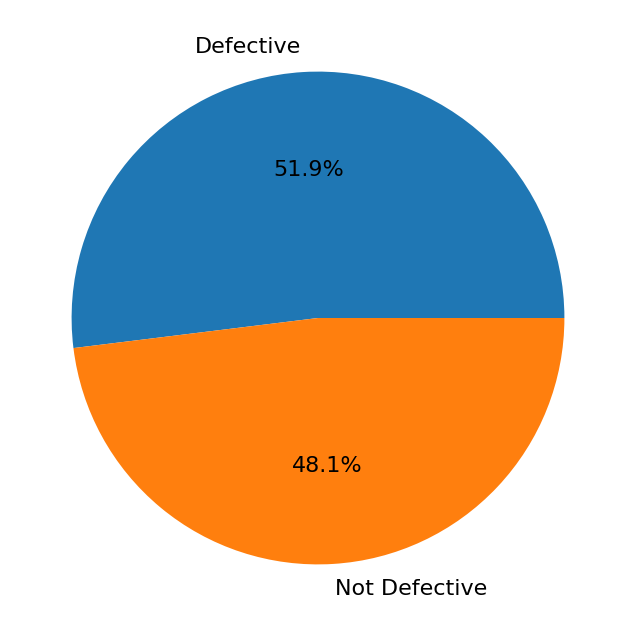

In [24]:
plt.rcParams['font.size'] = 16
plt.figure(figsize=(12,8))
labels = train_data.labels
vc = pd.Series(labels).value_counts()
plt.pie(vc, labels=['Defective', 'Not Defective'], autopct='%1.1f%%')
plt.show()

# Let's see some Chips

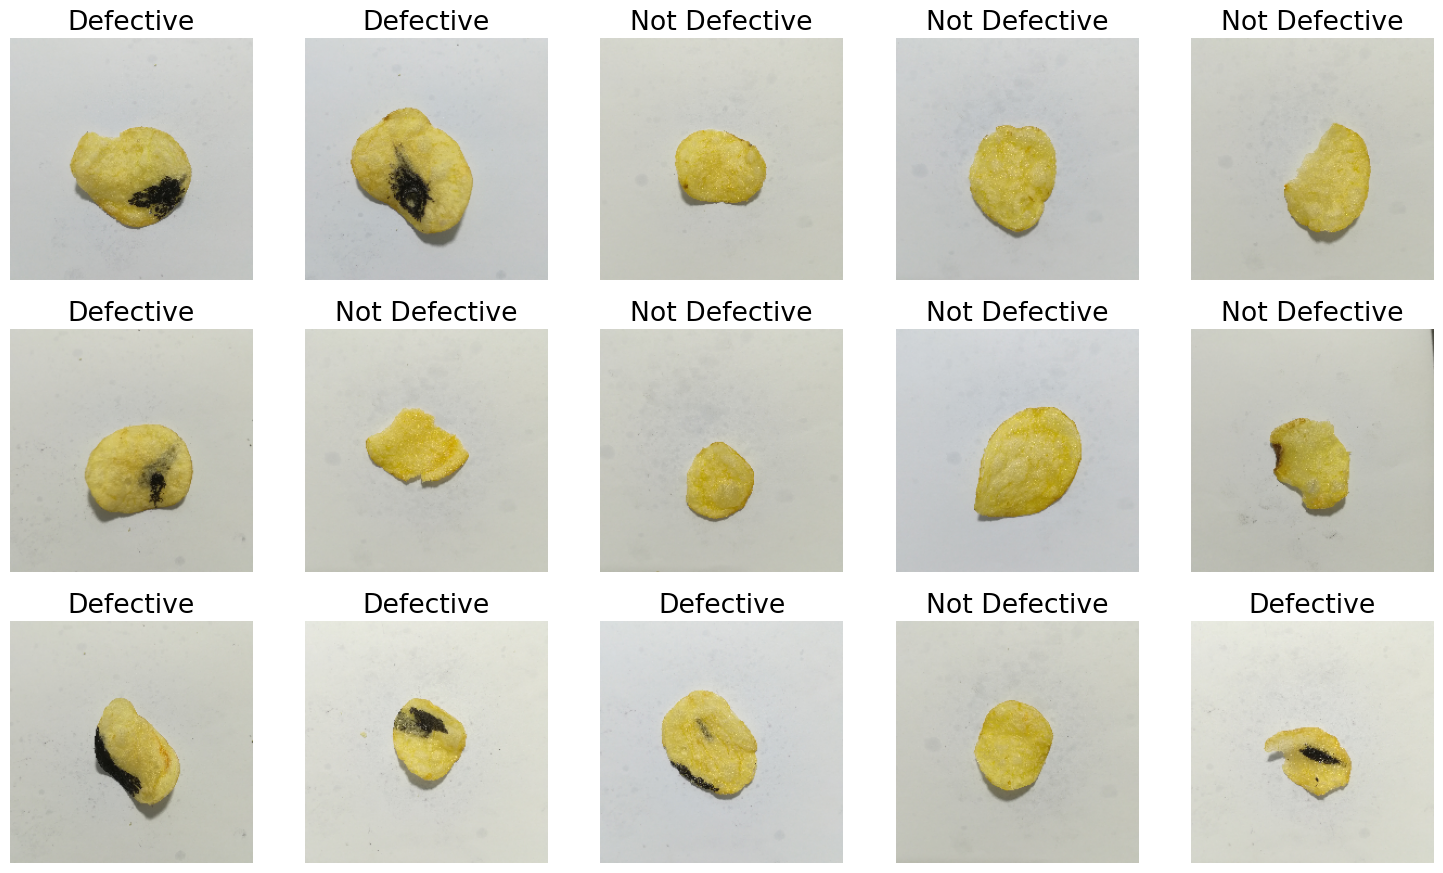

In [26]:
plt.figure(figsize=(15,9))

# Get one batch from the data generator
x, y = next(iter(train_data))

for i in range(15):
    axs = plt.subplot(3,5,i+1)
    # Use the first 15 images from the obtained batch
    plt.imshow(x[i])
    plt.axis('off')
    axs.set_title("Defective" if y[i] == 0 else "Not Defective")
    axs.set_xticklabels([])
    axs.set_yticklabels([])
    plt.subplots_adjust(wspace=None, hspace=None)
plt.tight_layout()

# Building the Model

For the Model building part, first approach is to begin with a small baseline model. Therefore, the first model will be a CNN trained from scratch

## Model 1

In [27]:
tf.random.set_seed(40)

model_1 = Sequential([
    Conv2D(64, 3, activation='relu'),
    Conv2D(64, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(32, 3, activation='relu'),
    Conv2D(16, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation='sigmoid')
])

model_1.compile(loss=BinaryCrossentropy(),
                optimizer=Adam(),
                metrics=['accuracy'])

history_1 = model_1.fit(train_data,
            epochs=5,
            steps_per_epoch=len(train_data),
            validation_data=valid_data,
            validation_steps=len(valid_data),
            callbacks=[checkpoint, earlystopping])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.5266 - loss: 0.7649 

20/20 ━━━━━━━━━━━━━━━━━━━━ 307s 15s/step - accuracy: 0.5263 - loss: 0.7633 - val_accuracy: 0.5229 - val_loss: 0.6889
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.5333 - loss: 0.6944 

20/20 ━━━━━━━━━━━━━━━━━━━━ 310s 15s/step - accuracy: 0.5378 - loss: 0.6927 - val_accuracy: 0.9216 - val_loss: 0.4864
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.8197 - loss: 0.7458 

20/20 ━━━━━━━━━━━━━━━━━━━━ 328s 15s/step - accuracy: 0.8221 - loss: 0.7356 - val_accuracy: 0.9739 - val_loss: 0.1690
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.9464 - loss: 0.1759 

20/20 ━━━━━━━━━━━━━━━━━━━━ 294s 15s/step - accuracy: 0.9471 - loss: 0.1736 - val_accuracy: 0.9869 - val_loss: 0.0498
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.9869 - loss: 0.0533 

20/20 ━━━━━━━━━━━━━━━━━━━━ 331s 15s/step - accuracy: 0.9868 - loss: 0.0536 - val_accuracy: 0.9935 - val_loss: 0.0428
Restoring model weights from the end of the best epoch: 5.


In [28]:
def plot_curves(history):

    """
    Returns separate loss and accuracy curves
    """

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("loss")
    plt.xlabel("epochs")
    plt.legend()

    plt.figure()
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("accuracy")
    plt.xlabel("epochs")
    plt.legend()

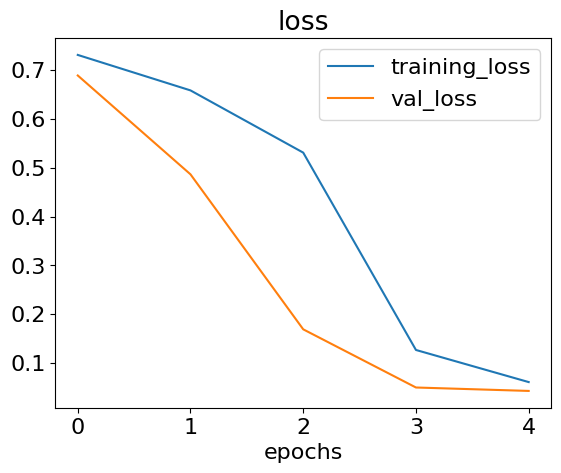

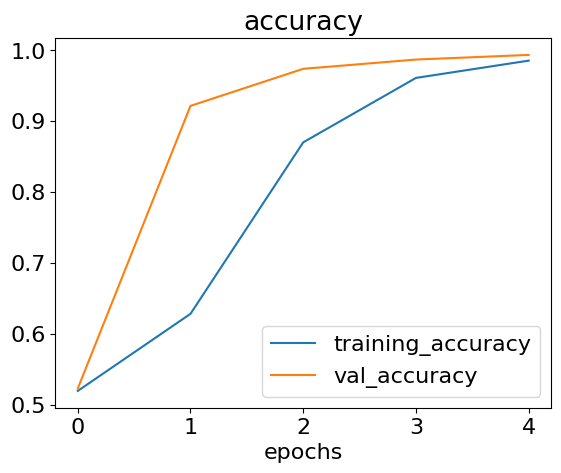

In [29]:
plot_curves(history_1)

In [30]:
result = model_1.evaluate(test_data, verbose=0)
print(f"Accuracy on Evaluation: {result[1]*100:.2f}%\nLoss: {result[0]:.4f}")

Accuracy on Evaluation: 98.44%
Loss: 0.0573


In [31]:
y_true = test_data.labels
y_pred = model_1.predict(test_data, verbose=0)
y_pred[y_pred < 0.5] = 0
y_pred[y_pred >= 0.5] = 1

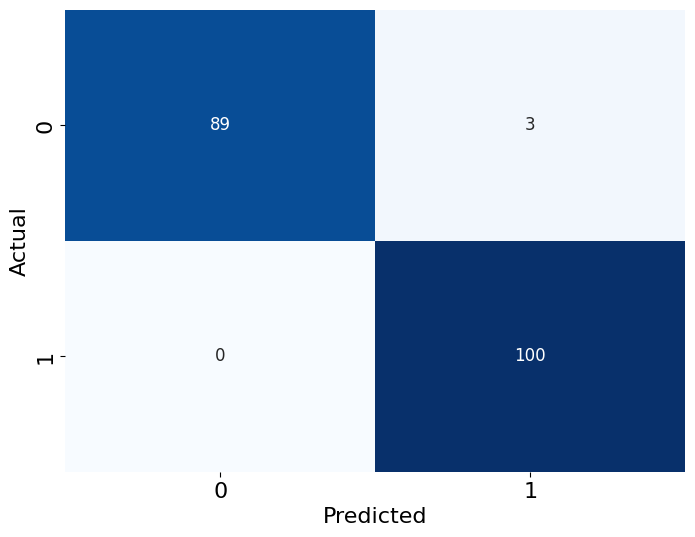

In [32]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_true,y_pred), cbar=False, annot=True, annot_kws={"fontsize":12}, fmt='.3g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

The Model performs astonishingly well! But there is a catch. The images that are being used are very clear and the angles are fixed. But what if there were distortions in Real world scenarios? To ensure that the model is better prepared for such "edge" cases, **Data Augmentation** is introduced

# Data Augmentation

In [33]:
train_datagen_augmented = IDG(rescale=1/255.,
                              rotation_range=0.2,
                              shear_range=0.2,
                              zoom_range=0.2,
                              brightness_range=(0.8, 1.2),
                              width_shift_range=0.3,
                              height_shift_range=0.3,
                              horizontal_flip=True,
                              validation_split=0.2)

train_data_aug = train_datagen_augmented.flow_from_directory(directory=train_dir,
                                               batch_size=BATCH_SIZE,
                                               target_size=IMAGE_SIZE,
                                               class_mode="binary",
                                               subset="training",
                                               seed=40)

Found 616 images belonging to 2 classes.


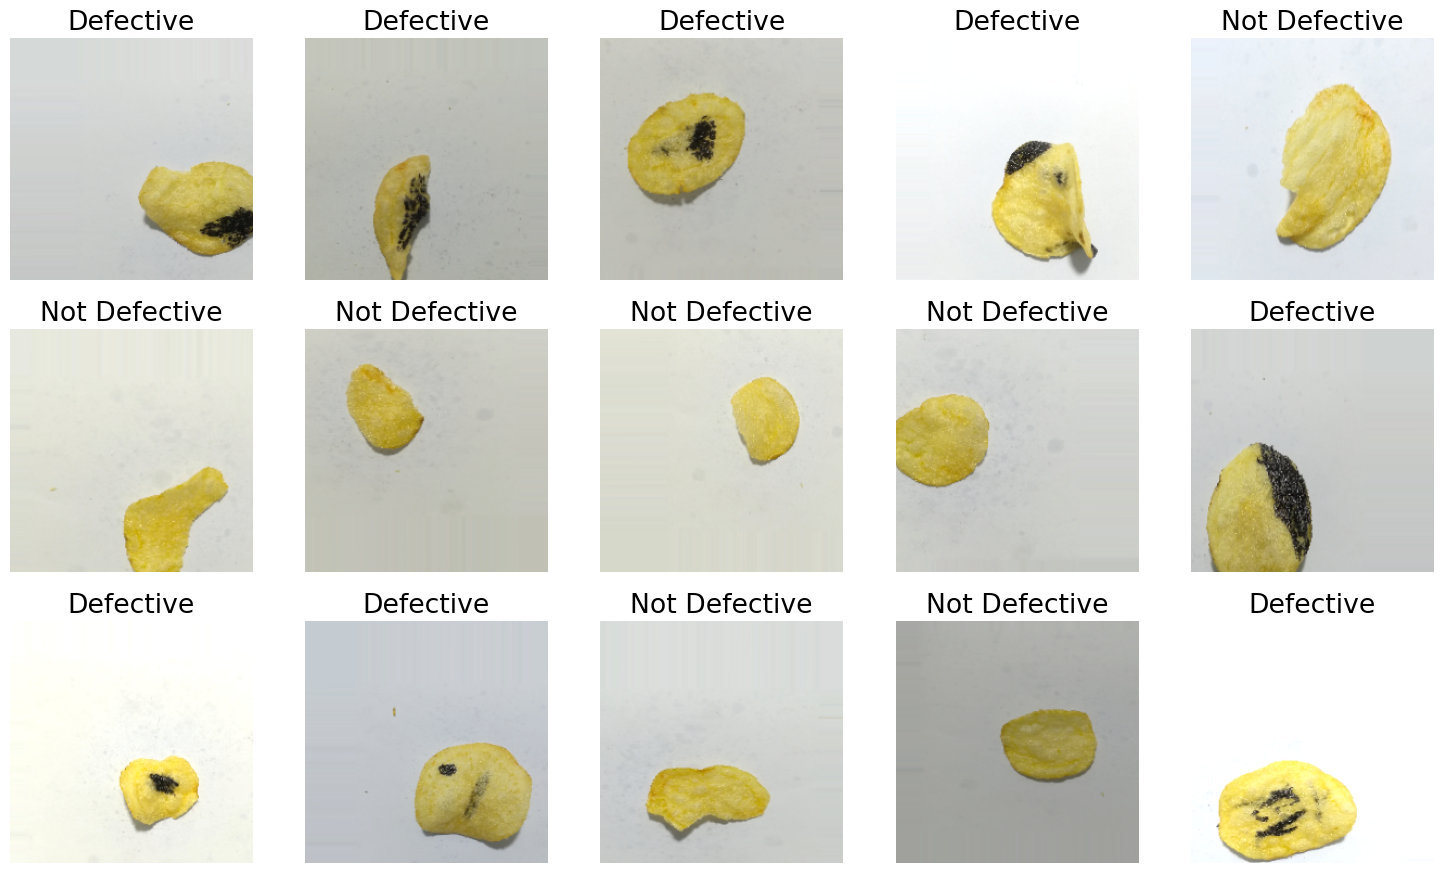

In [35]:
plt.figure(figsize=(15,9))

for i in range(15):
    axs = plt.subplot(3,5,i+1)
    # Use the next() built-in function to get the next batch
    x, y = next(train_data_aug)
    plt.imshow(x[i])
    plt.axis('off')
    axs.set_title("Defective" if y[i] == 0 else "Not Defective")
    axs.set_xticklabels([])
    axs.set_yticklabels([])
    plt.subplots_adjust(wspace=None, hspace=None)
plt.tight_layout()

## Model 2

In [36]:
tf.random.set_seed(40)

model_2 = Sequential([
    Conv2D(64, 3, activation='relu'),
    Conv2D(64, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(32, 3, activation='relu'),
    Conv2D(16, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation='sigmoid')
])

model_2.compile(loss=BinaryCrossentropy(),
                optimizer=Adam(learning_rate=0.001),
                metrics=['accuracy'])

history_2 = model_2.fit(train_data_aug,
            epochs=5,
            steps_per_epoch=len(train_data_aug),
            validation_data=valid_data,
            validation_steps=len(valid_data),
            callbacks=[checkpoint, earlystopping])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 317s 16s/step - accuracy: 0.4923 - loss: 0.7236 - val_accuracy: 0.4771 - val_loss: 0.6994
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 310s 15s/step - accuracy: 0.4929 - loss: 0.6992 - val_accuracy: 0.5229 - val_loss: 0.6942
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 302s 15s/step - accuracy: 0.5354 - loss: 0.6956 - val_accuracy: 0.4771 - val_loss: 0.6799
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 333s 16s/step - accuracy: 0.7081 - loss: 0.6664 - val_accuracy: 0.9804 - val_loss: 0.3472
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 309s 15s/step - accuracy: 0.8144 - loss: 0.5607 - val_accuracy: 0.9935 - val_loss: 0.1840
Restoring model weights from the end of the best epoch: 5.


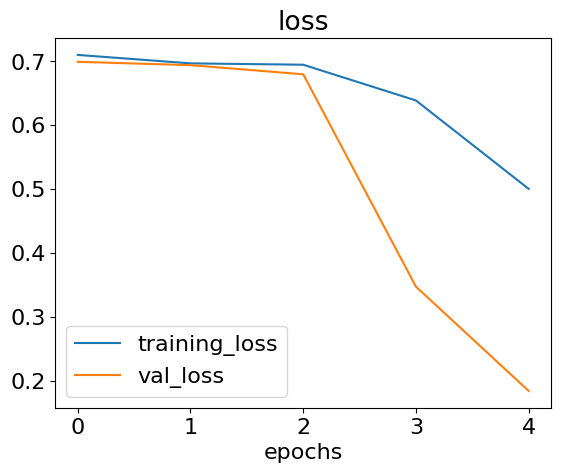

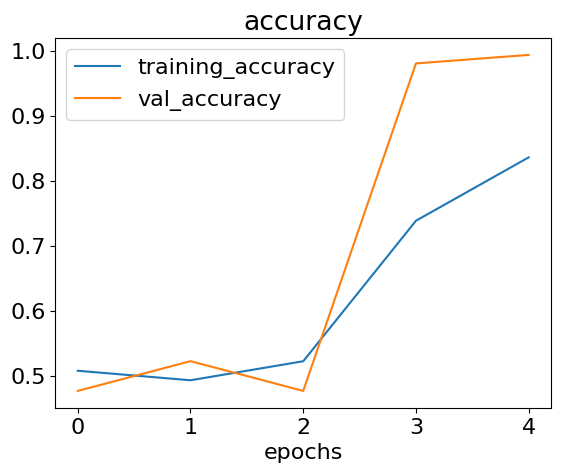

In [37]:
plot_curves(history_2)

In [38]:
result = model_2.evaluate(test_data, verbose=0)
print(f"Accuracy on Evaluation: {result[1]*100:.2f}%\nLoss: {result[0]:.4f}")

Accuracy on Evaluation: 96.35%
Loss: 0.2084


In [39]:
y_true = test_data.labels
y_pred = model_2.predict(test_data, verbose=0)
y_pred[y_pred < 0.5] = 0
y_pred[y_pred >= 0.5] = 1

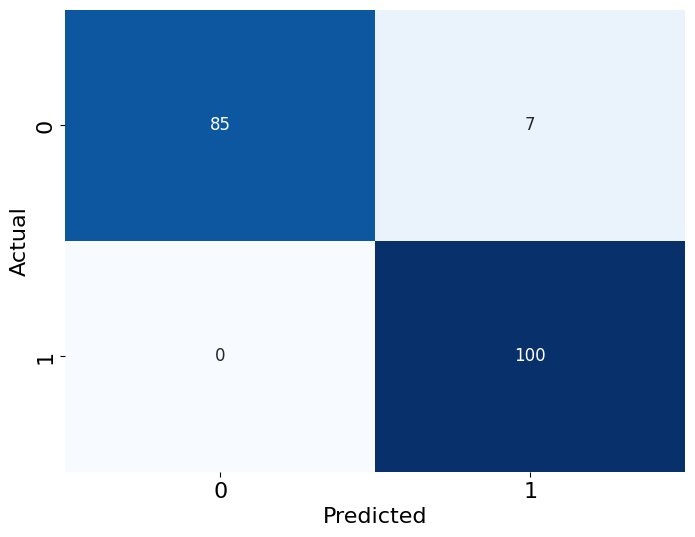

In [40]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_true,y_pred), cbar=False, annot=True, annot_kws={"fontsize":12}, fmt='.3g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Conclusion

Two models were trained for this classification task:
* Custom CNN model
* Custom CNN model with Data Augmentation

Both the models perform well, even when the images were heavily augmented. This indicates that the model will perform even when the input data is not absolutely clear.

### Future Work

While this experiment demonstrates the task on Potato chips dataset, it could be applied to any manufacturing application. There are a lot of anomalies that occur during such activites that can lead to disrupted supply chain operations. The working of this model can be deployed to analyse and fix these issues. While it doesn't necessary help identify the root cause, this application can save up costs and brand reputation by ensuring quality product.

* This model can be deployed on an edge device, like JETSON NANO by Nvidia
* Develop a CAD model to segregate products